## Yield curve prediction
A **yield curve** is a line that plots yields (interest rates) of bonds having equal credit quality but differing maturity dates. This yield curve is used as a benchmark for other debt in the market, such as mortgage rates or bank lending rates. The most frequently reported yield curve compares the 3-months, 2-years, 5-years, 10-years, and 30-years. The slope of the yield curve is an important indicator of short-term interest rates, for this reason yield curves are very important to investors in pension funds and insurance companies. The yield curve is a key representation of the state of the bond market. Investors watch the bond market closely as it is a strong predictor of future economic activity and levels of inflation, which affect prices of goods, financial assets, and real estate.

In this case study we will use supervised learning–based models to predict the yield curve. This case study is inspired by the paper [*Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting* by Manuel Nunes et al. (2018)](https://dx.doi.org/10.2139/ssrn.3144622).

### Loading the data
In this case study the predicted viariables are the 1month, 5years and 30years yield curve, that represent short, medium and long term tenors of the yield curve. In order to predict these, we need to understand what affects the movement of the yield curve. Some correlated variables that can influence the yield curve are:
- *Previous values of the treasury curve* for different tenors (usually 1m, 3m, 1y, 2y, 5y, 7y, 10y and 30y).
- *Percentage of the federal debt*, that can be held by the public, foreign governments or the federal reserve.
- *Corporate spread* on Baa-rated debt relative to the 10-year treasury rate

In [1]:
import pandas_datareader.data as web

tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
# Compute the percentage 
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

#### Define X and Y variables
The predicted variables (Y) are the rate for three tenors of the yield curve (i.e., 1month, 5years, and 30years). The number of trading days in a week is assumed to be five, and we compute the lagged version of the variables mentioned in the problem definition section as independent variables using five trading day lag. The lagged five day variables embed the time series component by using a time-delay approach, where the lagged variable is included as one of the independent variables.

In [7]:
return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

### Explorative data analysis

In [8]:
import pandas as pd
pd.options.display.precision = 3
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000,249.000
mean,1.977,2.139,2.725,1.964,2.079,2.158,2.103,2.132,2.248,2.322,2.720,0.155,0.776,0.259,2.158
std,2.091,1.472,1.023,2.079,2.123,2.024,1.806,1.467,1.348,1.235,1.019,0.032,0.019,0.024,0.410
min,0.000,0.220,1.220,0.000,0.010,0.040,0.110,0.220,0.390,0.550,1.220,0.091,0.736,0.229,1.490
25%,0.080,0.810,1.920,0.080,0.090,0.130,0.210,0.810,1.190,1.410,1.920,0.141,0.776,0.237,1.910
50%,1.550,1.720,2.350,1.550,1.570,1.670,1.630,1.720,1.830,1.900,2.350,0.163,0.782,0.255,2.110
75%,3.950,3.690,3.730,3.810,4.340,4.650,4.200,3.680,3.620,3.550,3.730,0.182,0.786,0.266,2.270
max,5.690,4.950,5.110,5.690,5.630,5.460,5.140,4.950,5.000,4.980,5.110,0.191,0.794,0.305,4.230


In [13]:
Y

,DGS1MO_pred,DGS5_pred,DGS30_pred
DATE,,,
2019-04-01,2.43,2.33,2.93
2019-04-08,2.42,2.37,2.96
2019-04-15,2.43,2.36,2.98
2019-04-23,2.43,2.28,2.93
2019-04-30,2.44,2.25,2.86
...,...,...,...
2024-01-31,5.47,4.06,4.31
2024-02-07,5.48,4.25,4.45
2024-02-14,5.49,4.33,4.47


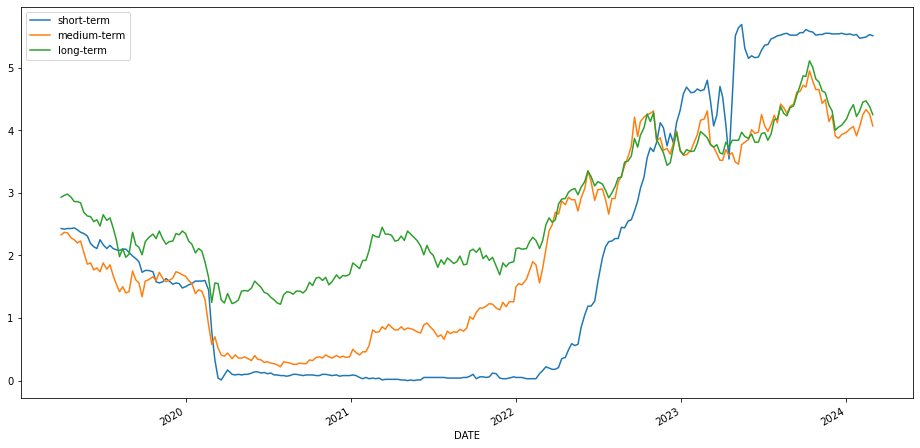

In [14]:
import matplotlib.pyplot as plt
Y.plot(figsize=(16,8))
plt.legend(['short-term','medium-term','long-term'])

<Axes: title={'center': 'Correlation Matrix'}>

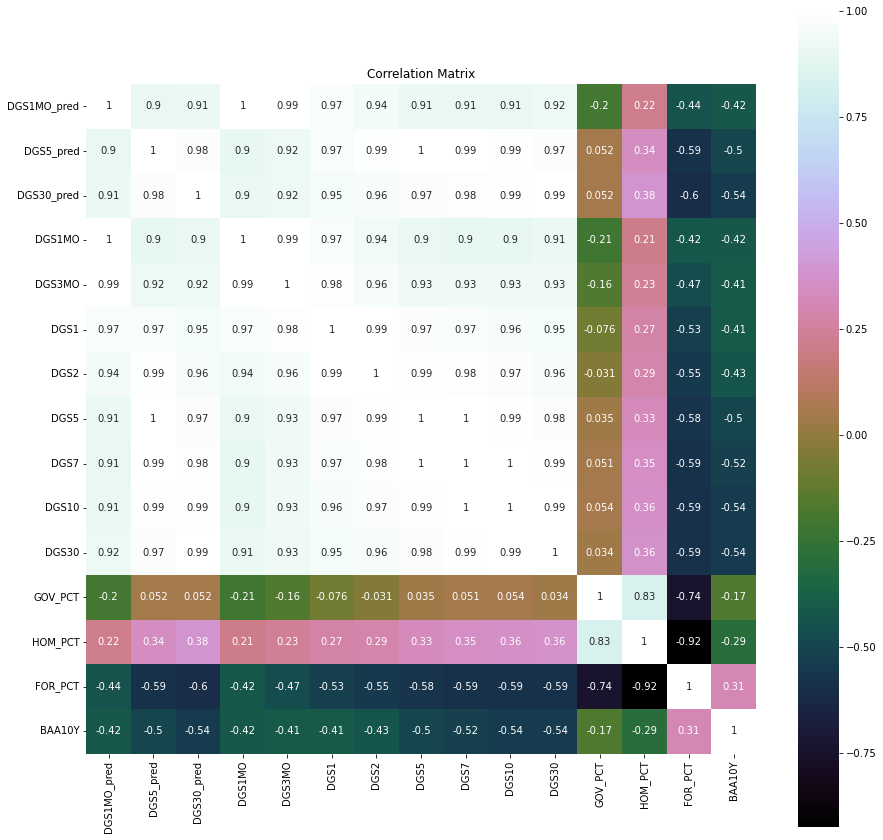

In [16]:
import seaborn as sns
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

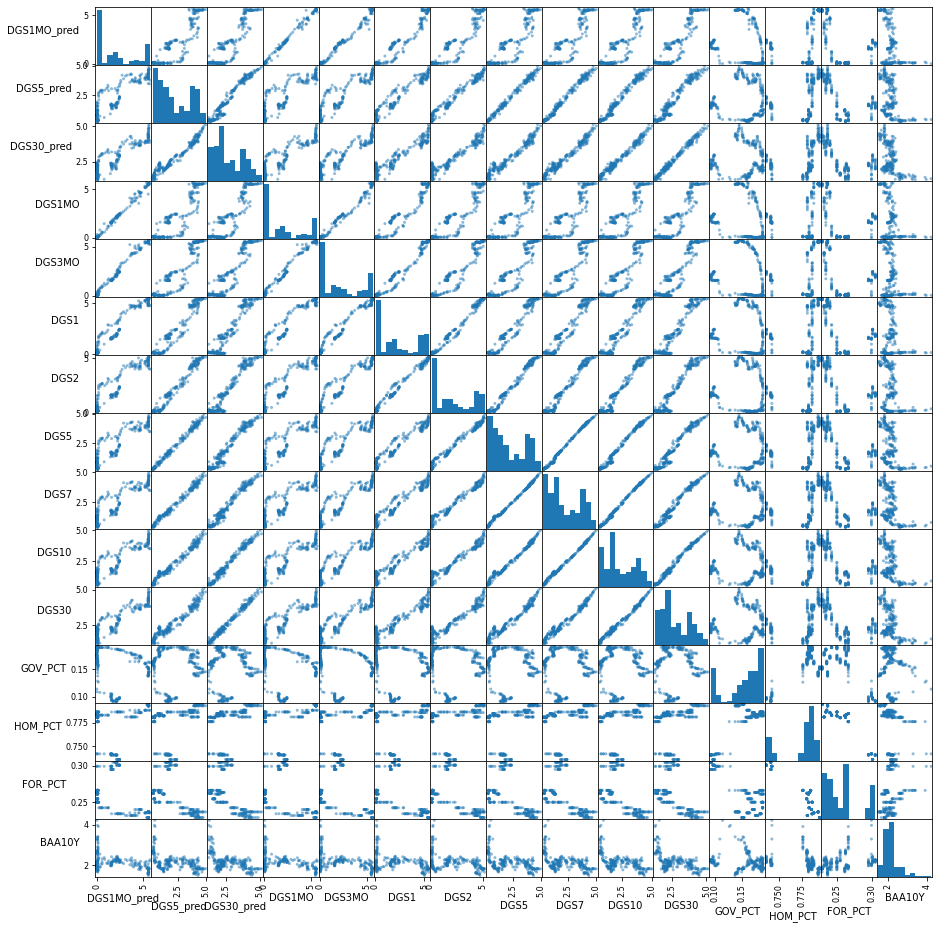

In [28]:
from pandas.plotting import scatter_matrix
# Scatterplot Matrix
plt.figure(figsize=(15,15))
plot = scatter_matrix(dataset,figsize=(15,16))
for ax in plot.flatten():
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

Looking at the scatterplot, we see a significant linear relationship of the predicted variables with their lags and other tenors of the yield curve. Overall, we see a lot of linear relationships, and we expect the linear models to perform well.
#### Time series analysis

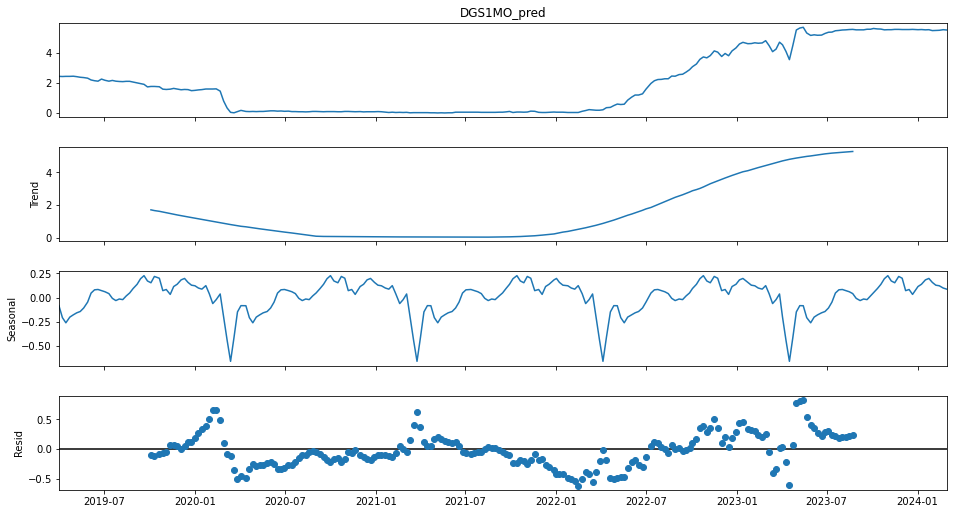

In [34]:
import statsmodels.api as sm

def time_series_analysis(time_series):
    res = sm.tsa.seasonal_decompose(time_series,period=52)
    fig = res.plot()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()
    
# 1 month
time_series_analysis(dataset['DGS1MO_pred'])

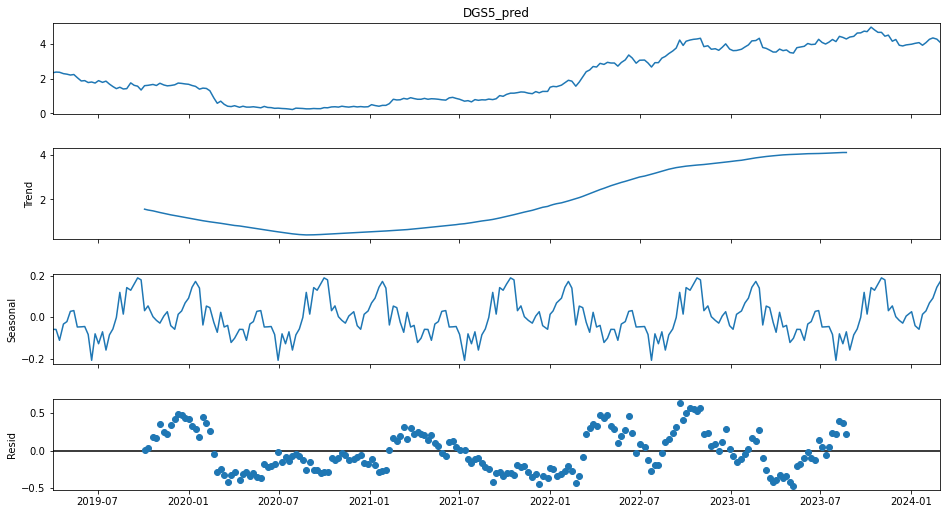

In [35]:
# 5 years
time_series_analysis(dataset['DGS5_pred'])

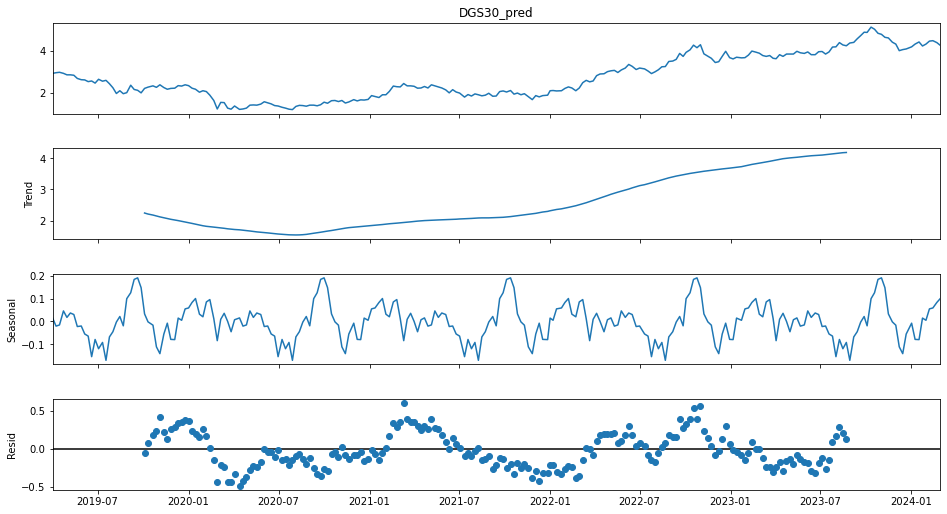

In [38]:
# 30 years
time_series_analysis(dataset['DGS30_pred'])

### Data analysis and preparation

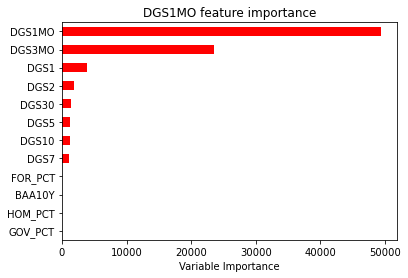

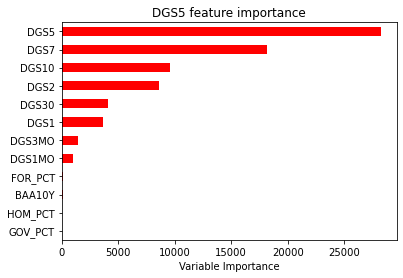

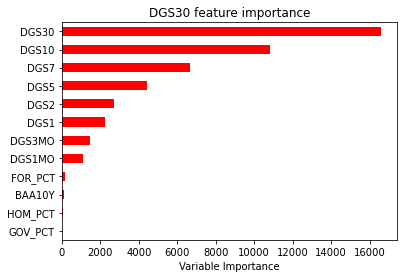

In [67]:
# Feature importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    Importance = pd.DataFrame({'Importance':fit.scores_}, index=X.columns)
    Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', legend=False)
    plt.xlabel('Variable Importance')
    plt.title(col[:-5]+' feature importance')

As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

### Evaluate models

In [74]:
from sklearn.model_selection import train_test_split
# Train-test split
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split randomly
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

num_folds = 10
scoring = 'neg_mean_squared_error'

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [80]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.018493888759869445 
Std CV Error: (0.006767776591464831) 
Training Error:
0.01610520999624792 
Test Error:
0.015954626137730767
----------
LASSO: 
Average CV error: 0.3277759116451398 
Std CV Error: (0.06543071519776053) 
Training Error:
0.3232466160495407 
Test Error:
0.254030949537221
----------
EN: 
Average CV error: 0.17763218260839414 
Std CV Error: (0.04193177005926043) 
Training Error:
0.17475011602539448 
Test Error:
0.13727250533120486
----------
KNN: 
Average CV error: 0.02400356807017544 
Std CV Error: (0.010795492566277098) 
Training Error:
0.016873098827470685 
Test Error:
0.013639760000000006
----------
CART: 
Average CV error: 0.041923280701754384 
Std CV Error: (0.017246577612744392) 
Training Error:
0.0 
Test Error:
0.030625333333333334
----------
MLP: 
Average CV error: 0.06590460971700575 
Std CV Error: (0.07942970139072014) 
Training Error:
0.025558139306258016 
Test Error:
0.018392630872404923
----------


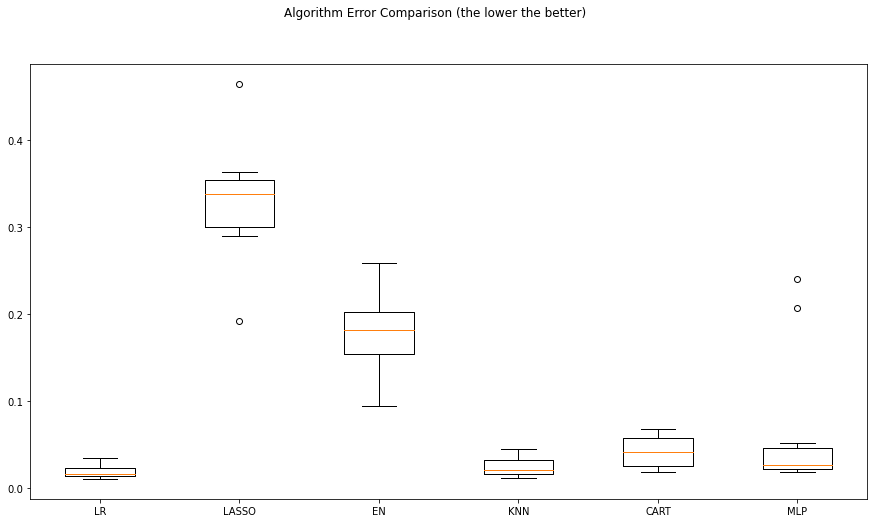

In [88]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Error Comparison (the lower the better)')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

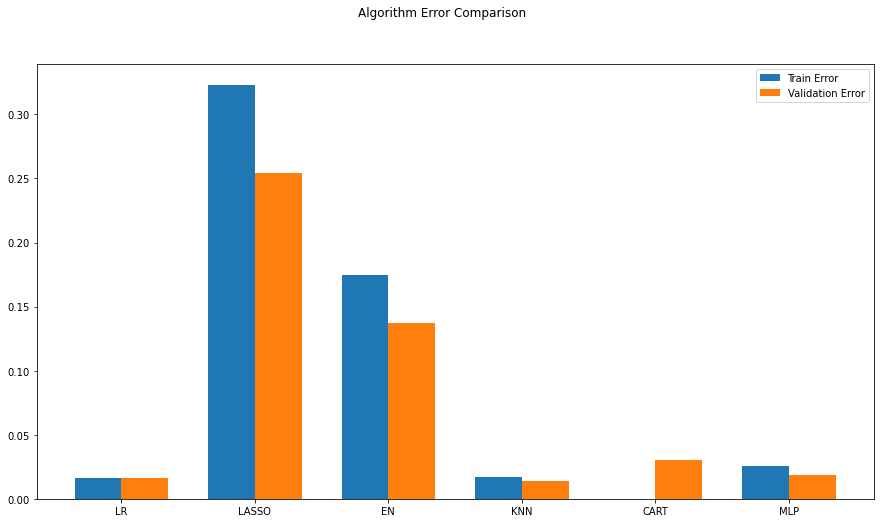

In [89]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Error Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
plt.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

We decide to use the MLP regressor (neural network).

### Model tuning and grid search

In [99]:
from sklearn.model_selection import GridSearchCV
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.074948 using {'hidden_layer_sizes': (20, 30, 20)}
-0.220522 (0.361357) with: {'hidden_layer_sizes': (20,)}
-0.142578 (0.218233) with: {'hidden_layer_sizes': (50,)}
-0.093478 (0.068911) with: {'hidden_layer_sizes': (20, 20)}
-0.074948 (0.057457) with: {'hidden_layer_sizes': (20, 30, 20)}


In [100]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30 , 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [102]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# Prepare Linear Regression model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.030040, MSE MLP = 0.173463
R2 Regression = 0.830669, R2 MLP = 0.120736


### Models comparison
We compare the performance of the MLP regressor and a linear regressor. We can see that the predictions of the two are comparable. This is due to the linear relationship of the predicted variables with their lags and other tenors of the yield curve. So the linear regression model, despite its simplicity, is a tough benchmark to beat for such one-step-ahead forecasting, given the dominant characteristic of the last available value of the variable to predict.

In [103]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<Axes: xlabel='DATE'>

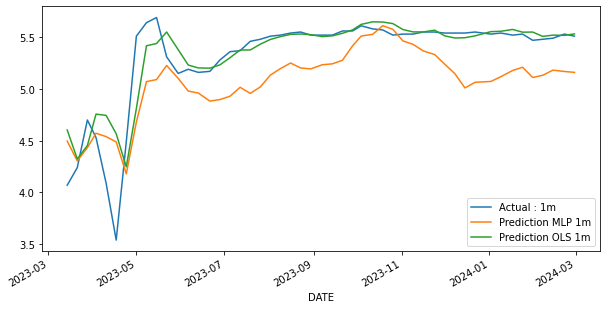

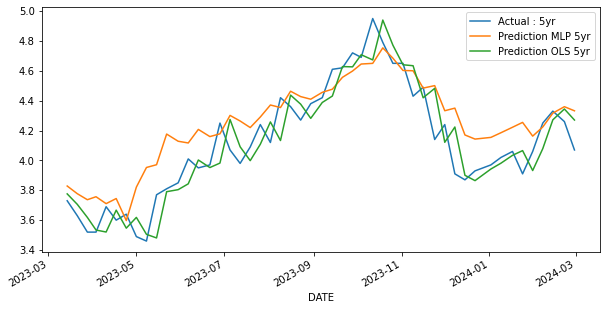

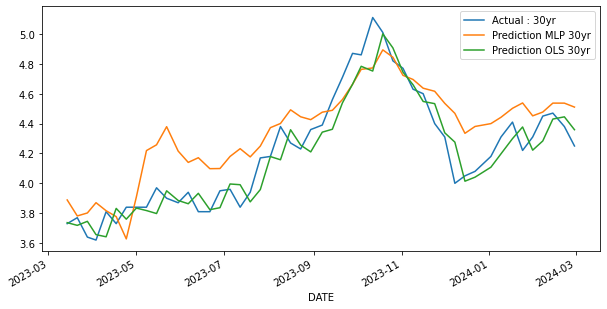

In [104]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))